# Sentiment Analysis with TF-IDF text representation

## Our Dataset

This dataset describes the contents of the heart-disease diagnosis.

The dataset in this study is from [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data), which is called Twitter US Airline Sentiment.

- Dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data

## Variable Table

| Original Dataset             | Data Type     | Description    |                                                         
|------------------------------|---------------|---------------------------------------------------------------------------------------------|
| tweet_id                     | ID            | A unique identifier for each tweet.                                                         | 
| airline_sentiment            | Categorical   | The sentiment expressed in the tweet (positive, neutral, negative).                         | 
| airline_sentiment_confidence | Numerical     | Confidence score in the sentiment label (0 to 1).                                           | 
| negativereason               | Categorical   | Reason for negative sentiment (e.g., "Late Flight", "Customer Service Issue").              | 
| negativereason_confidence    | Numerical     | Confidence score in the negative reason label (0 to 1).                                     | 
| airline                      | Categorical   | The airline mentioned in the tweet (e.g., United, Delta, etc.).                             | 
| airline_sentiment_gold       | Categorical   | Sentiment label by trusted annotator (gold standard).                                       | 
| name                         | Text          | Name of the user who posted the tweet.                                                      | 
| negativereason_gold          | Categorical   | Negative reason label by trusted annotator (gold standard).                                 | 
| retweet_count                | Numerical     | Number of times the tweet was retweeted.                                                    | 
| text                         | Text          | The full content of the tweet.                                                              | 
| tweet_coord                  | Geospatial    | Latitude and longitude coordinates where the tweet was posted, if available.                | 
| tweet_created                | Datetime      | Timestamp when the tweet was created.                                                       | 
| tweet_location               | Text          | Location specified in the user's profile.                                                   | 
| user_timezone                | Categorical   | Time zone specified in the user's profile.                                                  | 

<br/>

## Data Used for Modeling

| Feature                      | Data Type   | Description  |
|-----------------------------|-------------|--------------|
| **Target Variable: `encoded_sentiment`** | Categorical | This is an engineered variable derived from `airline_sentiment` for multi-class sentiment classification. It encodes sentiment as: 0 = Negative, 1 = Neutral, 2 = Positive. |
| **Feature: `text`**         | Text        | Contains consumer tweets about U.S. airlines. This field undergoes preprocessing, including removal of URLs and mentions (`@`), stopword removal, and stemming. |


<br/>

# 1. Load Data

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../../data/tweets.csv")

In [2]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [3]:
# Show the first few rows
df.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)

# 2. Data Preprocessing

## 2.1 Handle Duplicates

In [4]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

# Drop duplicate rows
df.drop_duplicates(inplace=True)

Number of duplicate rows: 36


In [5]:
# Confirm the shape after removal
print(f"Shape after dropping duplicates: {df.shape}")

Shape after dropping duplicates: (14604, 15)


## 2.2 Handle Missing Values

In [6]:
# Check for missing values for each variables in the dataset
print("\nMissing values count for each variables:")
print("-------------------------------------------")
print(df.isnull().sum())

print("""\n\n**Note**: We won't remove any rows with missing values here as 
our main field we use is 'text' and 'airline_sentiment' column,
which has no missing values""")


Missing values count for each variables:
-------------------------------------------
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5445
negativereason_confidence        4101
airline                             0
airline_sentiment_gold          14564
name                                0
negativereason_gold             14572
retweet_count                       0
text                                0
tweet_coord                     13589
tweet_created                       0
tweet_location                   4723
user_timezone                    4814
dtype: int64


**Note**: We won't remove any rows with missing values here as 
our main field we use is 'text' and 'airline_sentiment' column,
which has no missing values


## 2.3 Text Processing

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 2.3.1 Feature Engineering

For feature engineering in sentiment analysis, we will perform the following steps:

- `Tokenization`: Breaking the text into individual words or tokens.
- `Stopwords Removal`: Eliminating common words (e.g., "the", "is", "and") that don't contribute meaningful information.
- `Stemming`: Reducing words to their base or root form (e.g., "running" → "run", "happily" → "happy")."

In [8]:
import re

# Initialize stopwords, stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Step 1: Lowercase and clean the text
def clean_text(text):
    text = text.lower()                                 # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text)                    # Remove mentions
    # text = re.sub(r'#\w+', '', text)                    # NOTE: Do not remove hashtags, 
                                                                # as there is a lot of hashtags with sentiment indication, 
                                                                # such as '#thankyou', '#happycustomer', etc...
    text = re.sub(r'[^a-z\s]', '', text)                # Remove numbers and punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Step 2: Tokenization
def tokenize_text(text):
    return word_tokenize(text)

# Step 3: Remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Step 4: Apply Stemming
def apply_stemming(tokens):
    return " ".join([stemmer.stem(word) for word in tokens])

# Copy only the 'text' column to df_copy
df2 = df[['text', 'airline_sentiment']].copy()

# rule-based text processing for removing URL, twitter username and punctutations
df2['clean_text'] = df2['text'].apply(clean_text)

# procesed text after stemming
df2['tokens'] = df2['clean_text'].apply(tokenize_text)
df2['removed_stopwords'] = df2['tokens'].apply(remove_stopwords)
df2['stemmed'] = df2['removed_stopwords'].apply(apply_stemming)


In [9]:
df2.shape

(14604, 6)

In [10]:
# Check for missing values per column
print("\nMissing values per column:")
print(df2.isnull().sum())


Missing values per column:
text                 0
airline_sentiment    0
clean_text           0
tokens               0
removed_stopwords    0
stemmed              0
dtype: int64


### 2.3.2 Target Engineering

We will convert the 'airline_sentiment' column into numerical values to use it as the target variable in our model, where `negative` = 0, `neutral` = 1, and `positive` = 2 

In [11]:
print("The target variable contains unique values of: ", df2['airline_sentiment'].unique(), 
      "which we are going to map it into 0, 1 and 2 respectively")

# Encode the sentiment column
df2['encoded_sentiment'] = df2['airline_sentiment'].map({"negative": 0, "neutral": 1, "positive": 2})


The target variable contains unique values of:  ['neutral' 'positive' 'negative'] which we are going to map it into 0, 1 and 2 respectively


## 3.0 Data Preparation for Modeling

In [12]:
# Split into features (X) and target labels (y)
X = df2['stemmed']
y = df2['encoded_sentiment']

### 3.1 Train test split with stratified sampling

In [13]:
from sklearn.model_selection import train_test_split

# Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        stratify=y,            
                                        test_size=0.2, 
                                        random_state=42)

In [14]:
# Verify that class distribution is preserved after the train-test split (i.e., stratified correctly)

print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

print("""\n**Observation**: The class proportions appear to be preserved across the training and test sets, 
indicating a successful stratified split.""")

Train class distribution:
encoded_sentiment
0    0.627151
1    0.211675
2    0.161174
Name: proportion, dtype: float64

Test class distribution:
encoded_sentiment
0    0.627182
1    0.211571
2    0.161246
Name: proportion, dtype: float64

**Observation**: The class proportions appear to be preserved across the training and test sets, 
indicating a successful stratified split.


### 3.2 Text Representation with TF-IDF

TF-IDF (term frequency, inverse document frequency)  determines how important a word is by weighing its frequency of occurence in the document and computing how often the same word occurs in other documents. If a word occurs many times in a particular document but not in others, then it might be highly relevant to that particular document and is therefore assigned more importance.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### 3.3 Handling class imbalance issue with SMOTE

In [16]:
from imblearn.over_sampling import SMOTE

# Handling imbalanced using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

In [17]:
# Check class distribution before and after applying SMOTE to confirm successful balancing

print("Class distribution in training set (before SMOTE):")
print(y_train.value_counts())

print("\nClass distribution in training set (after SMOTE):")
print(y_train_resampled.value_counts())

print("""\n**Observation**: The class distribution in the training set has been balanced after applying SMOTE, 
confirming that oversampling was successful.""")


Class distribution in training set (before SMOTE):
encoded_sentiment
0    7327
1    2473
2    1883
Name: count, dtype: int64

Class distribution in training set (after SMOTE):
encoded_sentiment
0    7327
1    7327
2    7327
Name: count, dtype: int64

**Observation**: The class distribution in the training set has been balanced after applying SMOTE, 
confirming that oversampling was successful.


## 4.0 Modeling

(i) Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Predictions on training and test sets
y_train_pred_lr = model.predict(X_train_resampled)
y_test_pred_lr = model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.8699
Test Accuracy:  0.7675

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1832
           1       0.58      0.61      0.59       618
           2       0.64      0.69      0.66       471

    accuracy                           0.77      2921
   macro avg       0.70      0.71      0.71      2921
weighted avg       0.77      0.77      0.77      2921

Confusion Matrix (Test):
[[1539  199   94]
 [ 153  379   86]
 [  68   79  324]]


(ii) Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)

# Train the model
dt_model.fit(X_train_resampled, y_train_resampled)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_resampled)
y_test_pred_dt = dt_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.6909
Test Accuracy:  0.6484

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.81      0.69      0.75      1832
           1       0.40      0.53      0.46       618
           2       0.56      0.62      0.59       471

    accuracy                           0.65      2921
   macro avg       0.59      0.62      0.60      2921
weighted avg       0.68      0.65      0.66      2921

Confusion Matrix (Test):
[[1273  398  161]
 [ 221  327   70]
 [  84   93  294]]


(iii) XGBoost

In [20]:
import os
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the XGBoost Classifier
model_path = "../../models/tfidf_embedding_xgb_model.pkl"
if os.path.exists(model_path):
    print("Loading existing model...")
    gb_model = joblib.load(model_path)
else:
    # Train the model
    xgb_model = xgb.XGBClassifier(max_depth=10,
                                random_state=42,
                                # Introduce randomness to make training faster and reduce overfitting
                                subsample=0.8, ## Uses 80% of the data for each tree.
                                colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                                # the parameters below make the model trained faster by enabling parallelism
                                n_jobs = -1)
    xgb_model.fit(X_train_resampled, y_train_resampled)
    # Export and load previously trained model to avoid retraining every time
    joblib.dump(xgb_model, model_path)
    print("Model saved.")

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_resampled)
y_test_pred_xgb = xgb_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train_resampled, y_train_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))


Model saved.
Train Accuracy: 0.9213
Test Accuracy:  0.7658

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1832
           1       0.57      0.66      0.61       618
           2       0.70      0.64      0.67       471

    accuracy                           0.77      2921
   macro avg       0.71      0.71      0.71      2921
weighted avg       0.77      0.77      0.77      2921

Confusion Matrix (Test):
[[1527  225   80]
 [ 161  408   49]
 [  87   82  302]]


## 5.0 Text Mining with Decision Tree plot and SHAP value analysis

- Reference: https://medium.com/nlplanet/two-minutes-nlp-explain-predictions-with-shap-values-2a0e34219177

In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot decision tree
plt.figure(figsize=(200, 200))
plot_tree(dt_model, filled=True, max_depth=5, 
          feature_names=vectorizer.get_feature_names_out(), 
          class_names=["Negative", "Neutral", "Positive"])
plt.show()

In [22]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(dt_model,
                           X_train_resampled.toarray(), 
                           feature_names=vectorizer.get_feature_names_out())

# Compute SHAP values for the test set
shap_values = explainer(X_test_vectorized.toarray())

print(shap_values.values.shape)


 99%|===================| 8654/8763 [00:20<00:00]        

(2921, 8553, 3)


Original text:  thanks for helping my mom after wouldn't let her get on her plane in orlando! you're the best! #customerservice
Processed text:  thank help mom wouldnt let get plane orlando your best customerservic
------------------------

The original sentiment of the 3-rd text item is Positive
The predicted sentiment of the 3-rd text item is Positive
------------------------



Probability of Negative Sentiment, f(x='Negative')


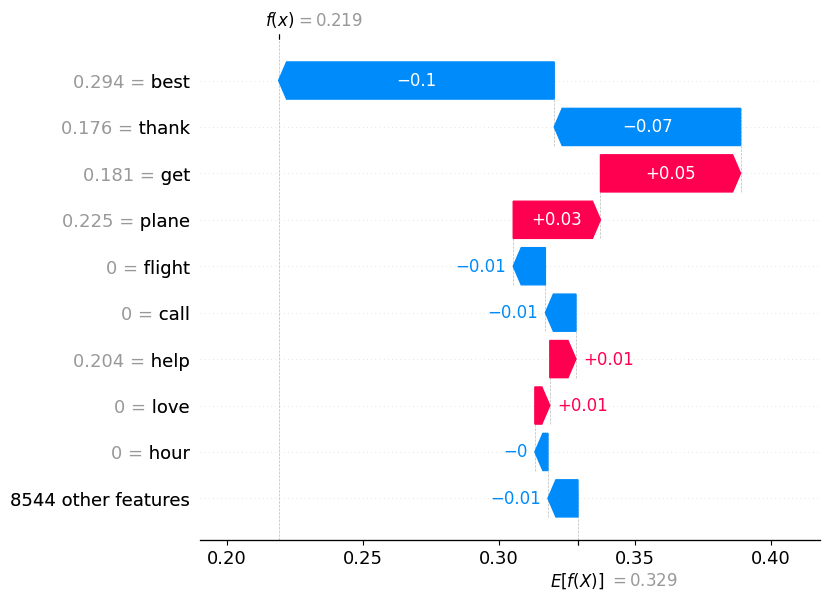

Probability of Neutral Sentiment, f(x='Neutral)


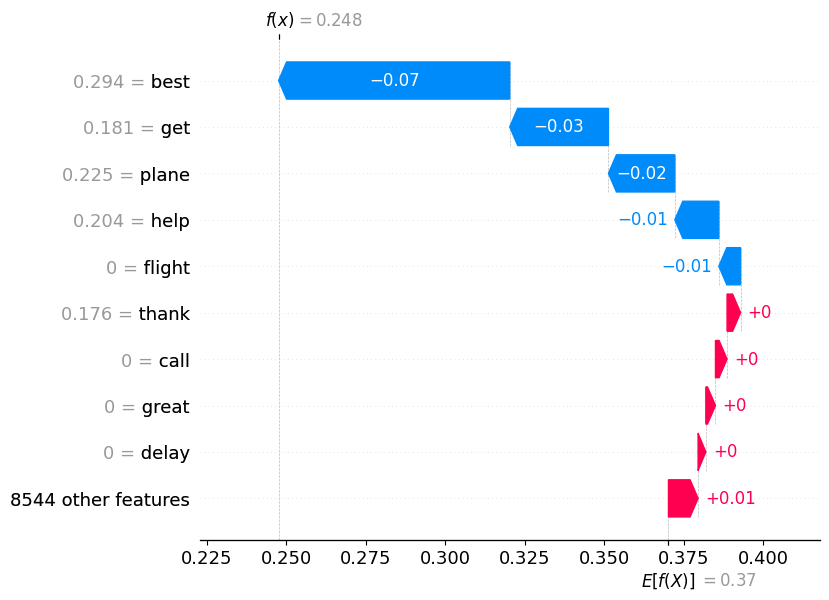

Probability of Positive Sentiment, f(x='Positive)


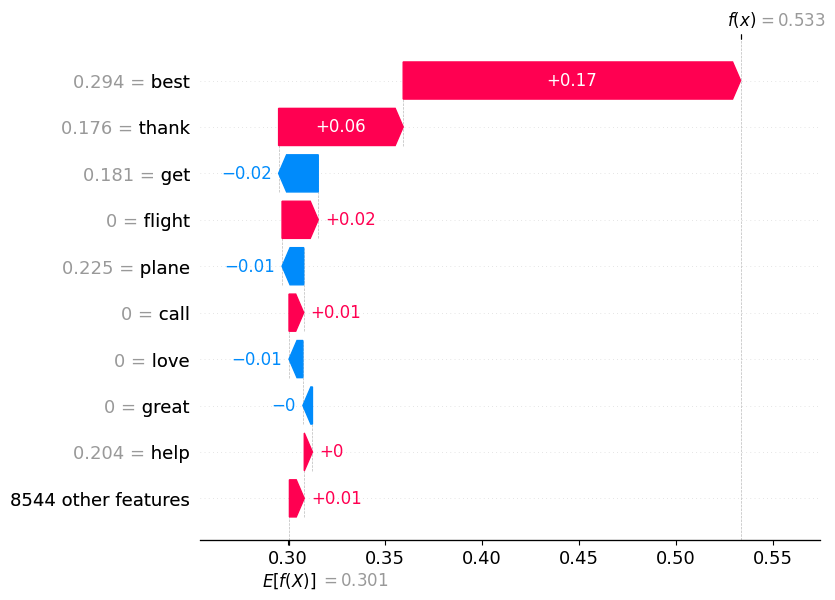

In [23]:
# SHAP value analysis for one of positive-sentiment comments
ind = 3

original_text = pd.read_csv("../../data/test.csv")["clean_text"].iloc[ind]
processed_text = X_test.iloc[ind]

print("Original text: ", original_text)
print("Processed text: ", processed_text)
print("------------------------\n")


print(f"The original sentiment of the {ind}-rd text item is",
      y_test.replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print(f"The predicted sentiment of the {ind}-rd text item is",
      pd.Series(y_test_pred_dt).replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print("------------------------\n")

shap.initjs()
print("Probability of Negative Sentiment, f(x='Negative')")
shap.plots.waterfall(shap_values[ind,:,0])

print("Probability of Neutral Sentiment, f(x='Neutral)")
shap.plots.waterfall(shap_values[ind,:,1])

print("Probability of Positive Sentiment, f(x='Positive)")
shap.plots.waterfall(shap_values[ind,:,2])

Original text:  will you be issuing an exception policy for denver for this weekend?
Processed text:  issu except polici denver weekend
------------------------

The original sentiment of the 2-th row of text item is Neutral
The predicted sentiment of the 2-th row of text item is Neutral
------------------------



Probability of Negative Sentiment, f(x='Negative')


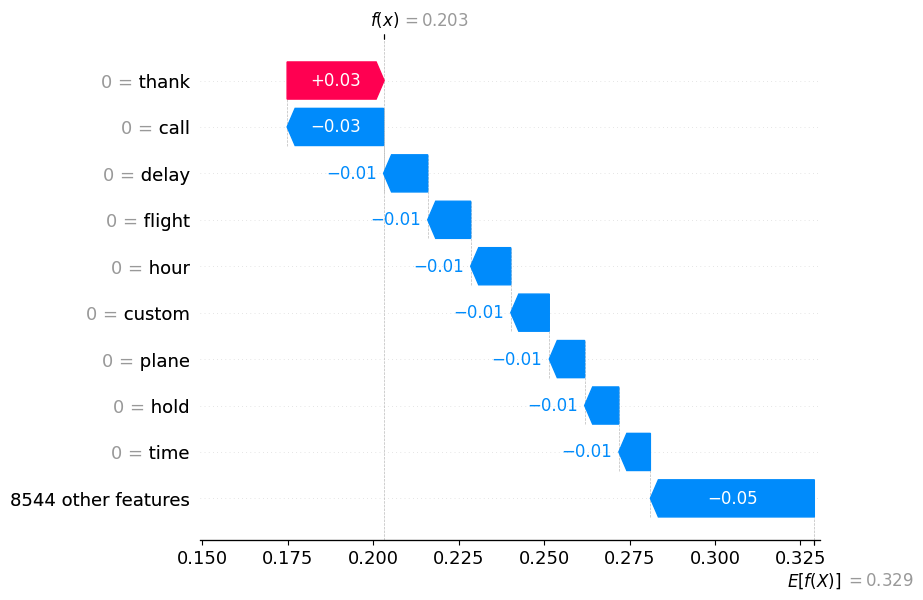

Probability of Neutral Sentiment, f(x='Neutral)


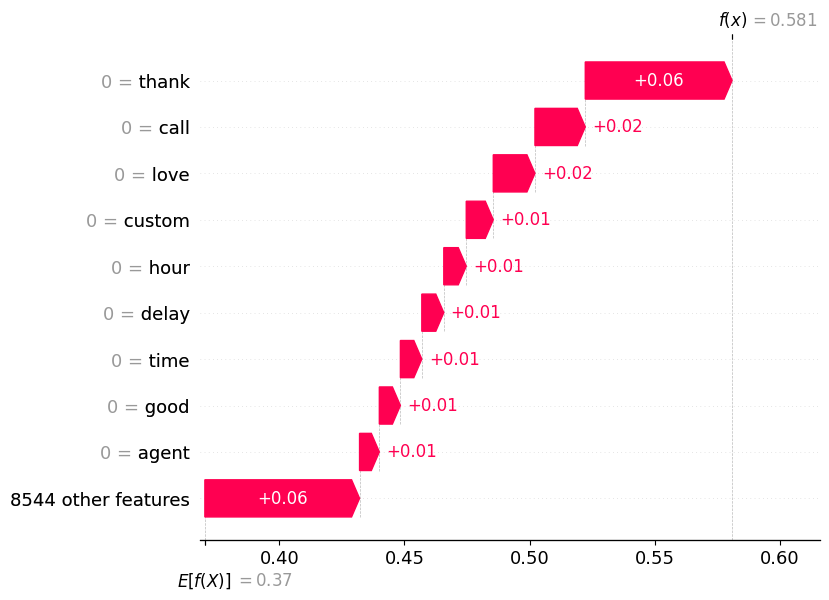

Probability of Positive Sentiment, f(x='Positive)


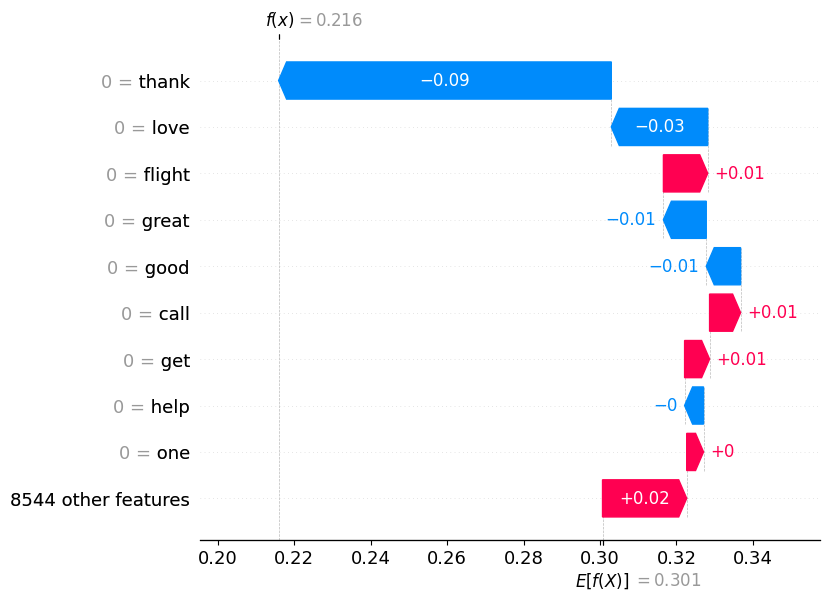

In [24]:
# Let’s do the same with a neutral review.

ind = 2

original_text = pd.read_csv("../../data/test.csv")["clean_text"].iloc[ind]
processed_text = X_test.iloc[ind]

print("Original text: ", original_text)
print("Processed text: ", processed_text)
print("------------------------\n")


print(f"The original sentiment of the {ind}-th row of text item is",
      y_test.replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print(f"The predicted sentiment of the {ind}-th row of text item is",
      pd.Series(y_test_pred_dt).replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print("------------------------\n")

shap.initjs()
print("Probability of Negative Sentiment, f(x='Negative')")
shap.plots.waterfall(shap_values[ind,:,0])

print("Probability of Neutral Sentiment, f(x='Neutral)")
shap.plots.waterfall(shap_values[ind,:,1])

print("Probability of Positive Sentiment, f(x='Positive)")
shap.plots.waterfall(shap_values[ind,:,2])

Original text:  me again! i was just trying to rebook fare on wanna get away pricing and it disappeared in time i refreshed. is this normal?
Processed text:  tri rebook fare wan na get away price disappear time refresh normal
------------------------

The original sentiment of the 9-th row of text item is Negative
The predicted sentiment of the 9-th row of text item is Negative
------------------------



Probability of Negative Sentiment, f(x='Negative')


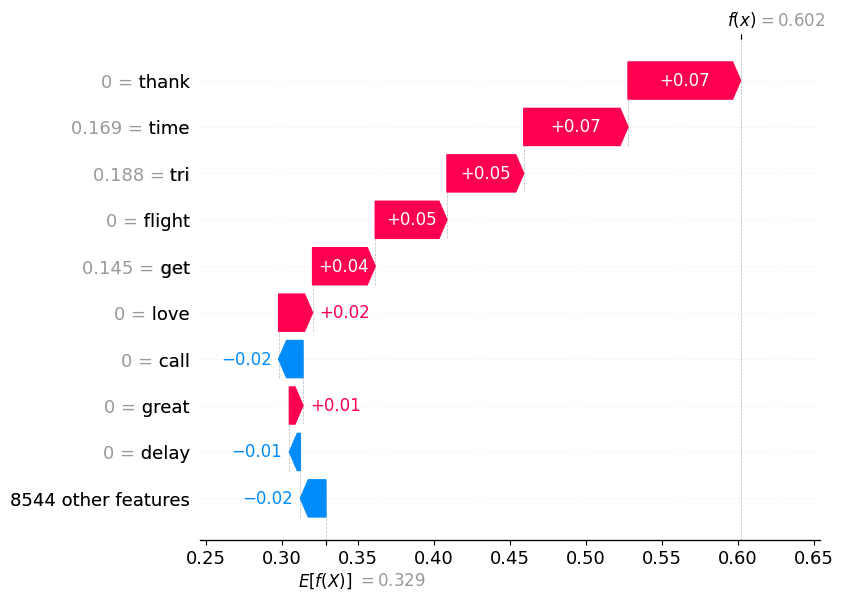

Probability of Neutral Sentiment, f(x='Neutral)


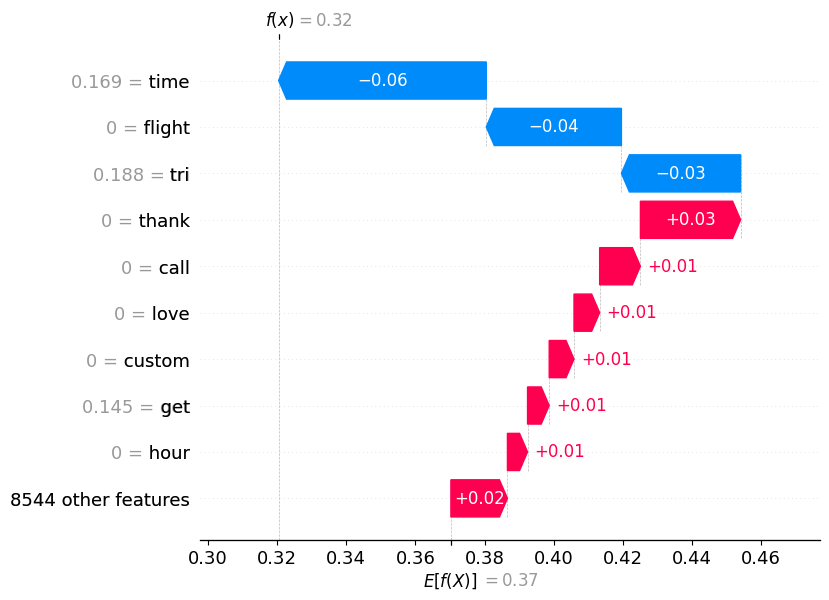

Probability of Positive Sentiment, f(x='Positive)


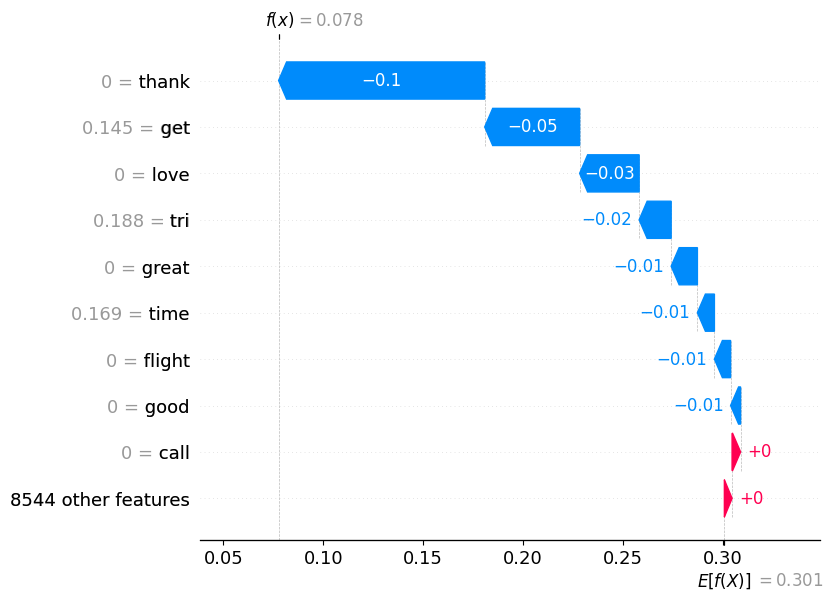

In [25]:
# Let’s do the same with a negative review.

ind = 9

original_text = pd.read_csv("../../data/test.csv")["clean_text"].iloc[ind]
processed_text = X_test.iloc[ind]

print("Original text: ", original_text)
print("Processed text: ", processed_text)
print("------------------------\n")


print(f"The original sentiment of the {ind}-th row of text item is",
      y_test.replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print(f"The predicted sentiment of the {ind}-th row of text item is",
      pd.Series(y_test_pred_dt).replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'}).iloc[ind])
print("------------------------\n")

shap.initjs()
print("Probability of Negative Sentiment, f(x='Negative')")
shap.plots.waterfall(shap_values[ind,:,0])

print("Probability of Neutral Sentiment, f(x='Neutral)")
shap.plots.waterfall(shap_values[ind,:,1])

print("Probability of Positive Sentiment, f(x='Positive)")
shap.plots.waterfall(shap_values[ind,:,2])